In [9]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [10]:
import json

In [11]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [12]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json


--2021-06-20 14:33:29--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.1.128, 108.177.121.128, 142.250.103.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.1.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.05s   

2021-06-20 14:33:29 (106 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [13]:
with open('/tmp/sarcasm.json','r') as f:
  data = json.load(f)

In [14]:
sentences = []
labels = []

for item in data:
  sentences.append(item['headline'])
  labels.append(item['is_sarcastic'])


In [15]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [16]:
tokenizer = Tokenizer(vocab_size, oov_tok,)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [17]:
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [20]:
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(vocab_size,embedding_dim, input_length = vocab_size),
                             tf.keras.layers.GlobalAveragePooling1D(),
                             tf.keras.layers.Dense(16,activation='relu'),
                             tf.keras.layers.Dense(1,activation='sigmoid')
                            
])

In [24]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics='accuracy')

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10000, 16)         160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


In [26]:
history = model.fit(training_padded,training_labels,epochs=30,validation_data=(testing_padded,testing_labels),verbose=2)

Epoch 1/30
625/625 - 3s - loss: 0.0355 - accuracy: 0.9895 - val_loss: 0.9584 - val_accuracy: 0.8170
Epoch 2/30
625/625 - 2s - loss: 0.0337 - accuracy: 0.9898 - val_loss: 0.9890 - val_accuracy: 0.8149
Epoch 3/30
625/625 - 2s - loss: 0.0333 - accuracy: 0.9900 - val_loss: 1.0280 - val_accuracy: 0.8140
Epoch 4/30
625/625 - 2s - loss: 0.0291 - accuracy: 0.9911 - val_loss: 1.0616 - val_accuracy: 0.8119
Epoch 5/30
625/625 - 2s - loss: 0.0284 - accuracy: 0.9918 - val_loss: 1.1057 - val_accuracy: 0.8138
Epoch 6/30
625/625 - 2s - loss: 0.0265 - accuracy: 0.9919 - val_loss: 1.1384 - val_accuracy: 0.8125
Epoch 7/30
625/625 - 2s - loss: 0.0249 - accuracy: 0.9929 - val_loss: 1.1604 - val_accuracy: 0.8131
Epoch 8/30
625/625 - 2s - loss: 0.0246 - accuracy: 0.9929 - val_loss: 1.1946 - val_accuracy: 0.8119
Epoch 9/30
625/625 - 2s - loss: 0.0238 - accuracy: 0.9930 - val_loss: 1.2263 - val_accuracy: 0.8104
Epoch 10/30
625/625 - 2s - loss: 0.0233 - accuracy: 0.9930 - val_loss: 1.3167 - val_accuracy: 0.8104

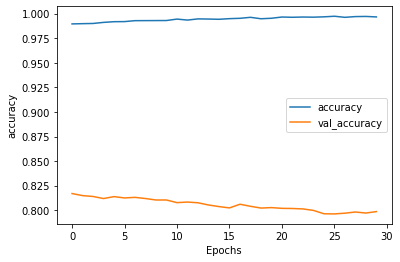

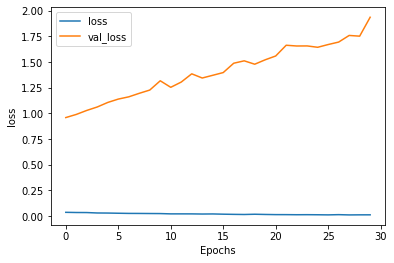

In [27]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [28]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

former store clerk sues over secret 'black for minority ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [30]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [31]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [32]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[8.792097e-01]
 [8.690431e-10]]
